In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import os
import math
import json
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
import mlflow
import mlflow.keras
from IPython.display import Audio

# Audio data preprocessing to extract MFCCs

In [2]:
# Define constants
DATASET_PATH = "../../dataset/audio/Data/genres_original"
SAMPLE_RATE = 22050
DURATION = 30 # in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION
NUMBER_SEGMENTS = 10 # the track is divided in differents segments
NUM_SAMPLES_PER_SEGMENT = int(SAMPLES_PER_TRACK / NUMBER_SEGMENTS)
HOP_LENGTH = 512

In [3]:
# Calculate the expected number of MFCC feature vectors per segment
expected_num_mfcc_vectors_per_segment = math.ceil(NUM_SAMPLES_PER_SEGMENT / HOP_LENGTH)

In [4]:
# Initialize dictionary to store processed dataset
data = {
    "mapping": [],
    "mfcc": [],
    "labels": [],
    "signals": []
}

In [5]:
# Loop through each genre and audio track to extract MFCCs per segment
for i, genre in enumerate(os.listdir(DATASET_PATH)): # browse all genre folders
    GENRE_PATH = DATASET_PATH + "/" + genre
    
    for track in  os.listdir(GENRE_PATH): # browse all music tracks in the genre folder
        TRACK_PATH = GENRE_PATH + "/" + track

        signal, sr = librosa.load(TRACK_PATH, sr=SAMPLE_RATE)

        # process segment extracting MFCCs
        for s in range(NUMBER_SEGMENTS): # divide each track in 10 segments
            start_sample = NUM_SAMPLES_PER_SEGMENT * s
            finish_sample = start_sample + NUM_SAMPLES_PER_SEGMENT
            
            mfcc = librosa.feature.mfcc(y=signal[start_sample:finish_sample],
                                    sr=SAMPLE_RATE,
                                    n_fft=2048,
                                    n_mfcc=13,
                                    hop_length=HOP_LENGTH)
            mfcc = mfcc.T

            # store mfcc for segment if it has the expected length
            if len(mfcc) == expected_num_mfcc_vectors_per_segment:
                data["mfcc"].append(mfcc.tolist())
                data["labels"].append(i)
                data["mapping"].append(genre)
                data["signals"].append(signal[start_sample:finish_sample].tolist())  # Store raw audio segment

In [6]:
# Print the total number of samples (segments)
print(f"Number of segments (samples): {len(data['mfcc'])}")

# Check the shape of one MFCC example
sample_mfcc = np.array(data["mfcc"][0])
print(f"Shape of one MFCC segment: {sample_mfcc.shape}")

# Check the size of other elements
print(f"Number of labels: {len(data['labels'])}")
print(f"Number of genre mappings: {len(set(data['mapping']))}")

Number of segments (samples): 9986
Shape of one MFCC segment: (130, 13)
Number of labels: 9986
Number of genre mappings: 10


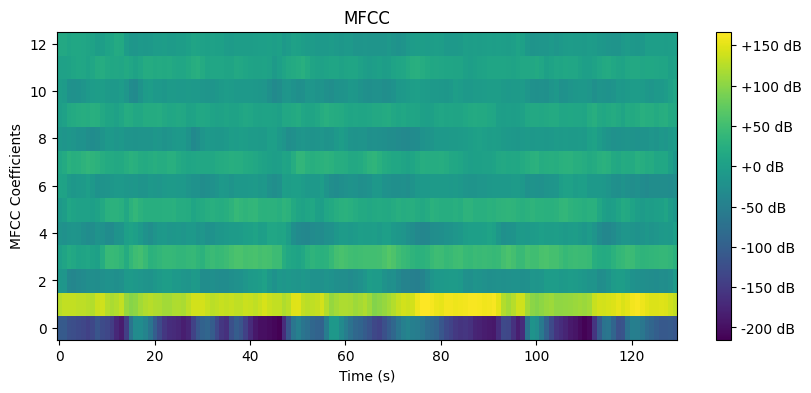

In [7]:
# Display a MFCC example
mfcc_example = data["mfcc"][3]

# Convert the list to a numpy array for easier manipulation
mfcc_example = np.array(mfcc_example)

# Plot the MFCC
plt.figure(figsize=(10, 4))
plt.imshow(mfcc_example.T, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC')
plt.xlabel('Time (s)')
plt.ylabel('MFCC Coefficients')
plt.show()

In [8]:
# Define a function to play a segment
def play_segment(segment_index, sample_rate=SAMPLE_RATE):
    """
    Play the raw audio of a specific segment by index.

    Parameters:
        segment_index (int): Index of the segment to play.
        sample_rate (int): Sampling rate used to load the audio.
    """
    audio = np.array(data["signals"][segment_index])
    return Audio(audio, rate=sample_rate)

In [9]:
play_segment(3)

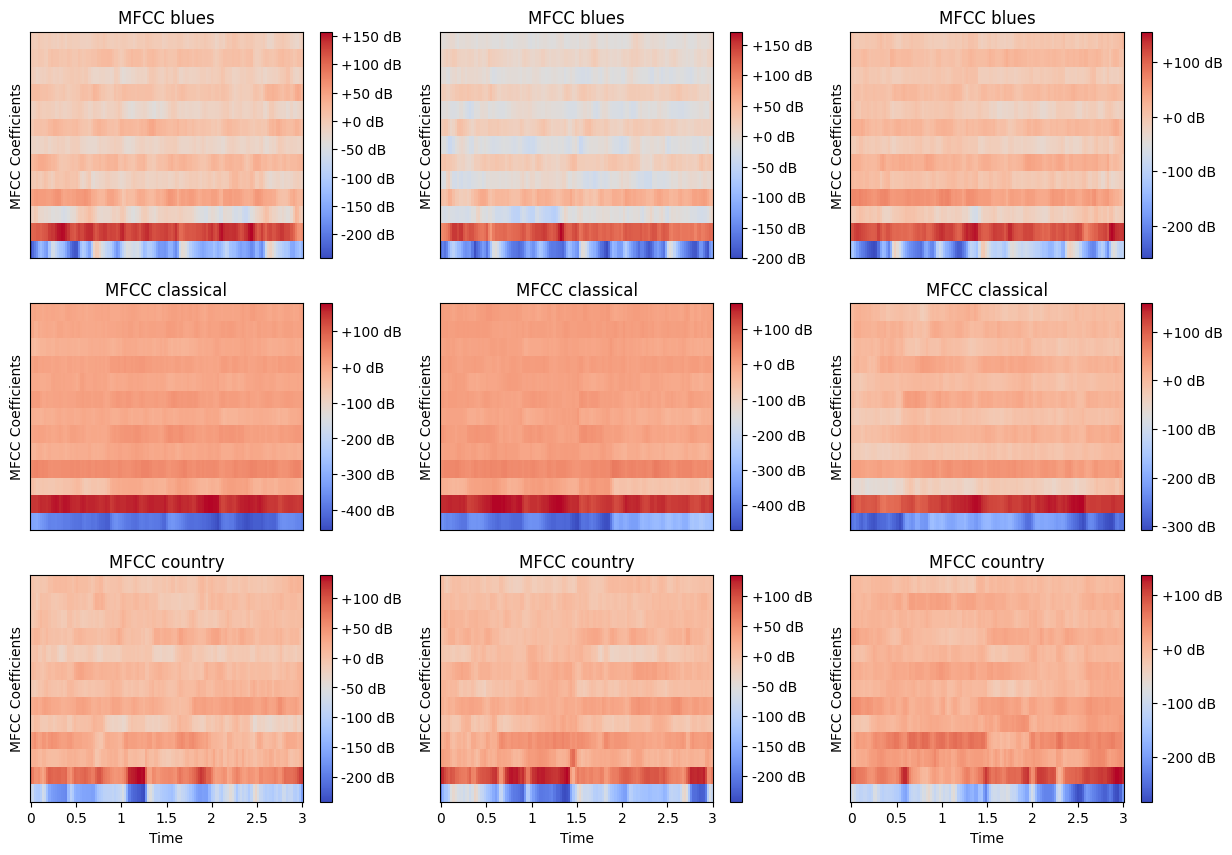

In [10]:
# Display MFCCs from several samples across different genres
# to visually assess MFCC patterns and their variability
plt.figure(figsize=(15, 10))

for i in range(0, 3):
    mfcc_example = data["mfcc"][i]
    # Convert the list to a numpy array for easier manipulation
    mfcc_example = np.array(mfcc_example)
    # Transpose the MFCC array
    mfcc_example = mfcc_example.T    
    
    plt.subplot(3, 3, i+1)
    librosa.display.specshow(mfcc_example, sr=SAMPLE_RATE)
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'MFCC {data["mapping"][i]}')
    plt.ylabel('MFCC Coefficients')

for i in range(0, 3):
    mfcc_example = data["mfcc"][i+1100]
    # Convert the list to a numpy array for easier manipulation
    mfcc_example = np.array(mfcc_example)
    # Transpose the MFCC array
    mfcc_example = mfcc_example.T    
    
    plt.subplot(3, 3, i+4)
    librosa.display.specshow(mfcc_example, sr=SAMPLE_RATE)
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'MFCC {data["mapping"][i+1100]}')
    plt.ylabel('MFCC Coefficients')

for i in range(0, 3):
    mfcc_example = data["mfcc"][i+2200]
    # Convert the list to a numpy array for easier manipulation
    mfcc_example = np.array(mfcc_example)
    # Transpose the MFCC array
    mfcc_example = mfcc_example.T    
    
    plt.subplot(3, 3, i+7)
    librosa.display.specshow(mfcc_example, x_axis='time', sr=SAMPLE_RATE)
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'MFCC {data["mapping"][i+2200]}')
    plt.xlabel('Time')
    plt.ylabel('MFCC Coefficients')

plt.tight_layout
plt.show()

In [11]:
play_segment(2201)

In [12]:
# Create a smaller version of the data dictionary
data_to_save = {
    "mapping": data["mapping"],
    "mfcc": data["mfcc"],
    "labels": data["labels"]
}

# Save the reduced data to a JSON file
with open("data.json", "w") as fp:
    json.dump(data_to_save, fp, indent=4)

# Implementing a neural network for music genre classification

In [13]:
# Load MFCC features and corresponding labels from a JSON file
def load_data(dataset_path):
    with open(dataset_path, "r") as fp:
        data = json.load(fp)

    # convert list into numpy array
    inputs = np.array(data["mfcc"])
    targets = np.array(data["labels"])

    return inputs, targets

In [14]:
inputs, targets = load_data("data.json")

In [15]:
# verify shapes
print("inputs shape : ", inputs.shape)
print("targets shape : ", targets.shape)
print("targets details :")
s = pd.Series(targets)
s.value_counts()

inputs shape :  (9986, 130, 13)
targets shape :  (9986,)
targets details :


0    1000
6    1000
7    1000
8    1000
9    1000
1     999
2     999
3     999
4     999
5     990
Name: count, dtype: int64

In [16]:
# Set the experiment name
experiment_name = "Audio_classification_experiment"
mlflow.set_experiment(experiment_name)

2025/07/25 14:54:18 INFO mlflow.tracking.fluent: Experiment with name 'Audio_classification_experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///C:/Users/OmenH/Documents/Python/projets/audio_genre_classification/mlruns/286958595763930673', creation_time=1753448058336, experiment_id='286958595763930673', last_update_time=1753448058336, lifecycle_stage='active', name='Audio_classification_experiment', tags={}>

## Implement basic neural network as a baselin model

In [17]:
# Split the data into training and testing sets
inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs, targets, test_size=0.3)

# Define and compile a feedforward neural network for classification
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(inputs.shape[1], inputs.shape[2])),
    keras.layers.Dense(512, activation="relu"),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

# Compile the model with Adam optimizer and categorical cross-entropy loss
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Start an MLflow run to track parameters, metrics, and the model
with mlflow.start_run(run_name="base_model"):
    # Train the model with validation split
    history = model.fit(inputs_train, targets_train,
                        validation_data=(inputs_test, targets_test),
                        epochs=30,
                        batch_size=32)

    # Log the trained model and key training parameters to MLflow
    mlflow.keras.log_model(model, "model")
    mlflow.log_param("epochs", 30)
    mlflow.log_param("batch_size", 32)
    mlflow.log_param("learning_rate", 0.0001)

    # Log training and validation metrics for each epoch
    for epoch in range(len(history.history['loss'])):
        mlflow.log_metric("loss", history.history['loss'][epoch], step=epoch)
        mlflow.log_metric("accuracy", history.history['accuracy'][epoch], step=epoch)
        mlflow.log_metric("val_loss", history.history['val_loss'][epoch], step=epoch)
        mlflow.log_metric("val_accuracy", history.history['val_accuracy'][epoch], step=epoch)

    # Evaluate the final model on the test set and log final metrics
    test_loss, test_acc = model.evaluate(inputs_test, targets_test)
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("test_accuracy", test_acc)

C:\Users\OmenH\anaconda3\envs\OCProjectEnv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.2534 - loss: 17.9948 - val_accuracy: 0.3712 - val_loss: 4.7368
Epoch 2/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4151 - loss: 3.2398 - val_accuracy: 0.4262 - val_loss: 2.8025
Epoch 3/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4889 - loss: 2.1375 - val_accuracy: 0.4316 - val_loss: 2.5644
Epoch 4/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5484 - loss: 1.6583 - val_accuracy: 0.4593 - val_loss: 2.4715
Epoch 5/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5910 - loss: 1.4553 - val_accuracy: 0.4723 - val_loss: 2.3063
Epoch 6/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6545 - loss: 1.1554 - val_accuracy: 0.4856 - val_loss: 2.1248
Epoch 7/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7073 - loss: 0.9754 - val_accuracy: 0.4920 - val_loss: 2.2392
Epoch 8/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7390 - loss: 0.8414 - val_accuracy: 0

2025/07/25 14:55:17 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/25 14:55:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5455 - loss: 2.6318


## Reducing Overfitting

In [18]:
# Split the data into training and testing sets
inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs, targets, test_size=0.3)

# Define and compile a feedforward neural network for classification
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(inputs.shape[1], inputs.shape[2])),
    keras.layers.Dense(512, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(10, activation="softmax")
])

# Compile the model with Adam optimizer and categorical cross-entropy loss
optimizer = keras.optimizers.Adam(learning_rate=0.00015)
model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Start an MLflow run to track parameters, metrics, and the model
with mlflow.start_run(run_name="adding_dropout_and_L2"):
    # Train the model with validation split
    history = model.fit(inputs_train, targets_train,
                        validation_data=(inputs_test, targets_test),
                        epochs=50,
                        batch_size=32)

    # log key data into MLFlow
    mlflow.keras.log_model(model, "model")
    mlflow.log_param("epochs", 30)
    mlflow.log_param("batch_size", 32)
    mlflow.log_param("learning_rate", 0.00015)

    for epoch in range(len(history.history['loss'])):
        mlflow.log_metric("loss", history.history['loss'][epoch], step=epoch)
        mlflow.log_metric("accuracy", history.history['accuracy'][epoch], step=epoch)
        mlflow.log_metric("val_loss", history.history['val_loss'][epoch], step=epoch)
        mlflow.log_metric("val_accuracy", history.history['val_accuracy'][epoch], step=epoch)

    # Evaluate the final model on the test set and log final metrics
    test_loss, test_acc = model.evaluate(inputs_test, targets_test)
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("test_accuracy", test_acc)

Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.1589 - loss: 35.2715 - val_accuracy: 0.2340 - val_loss: 3.3753
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.1649 - loss: 5.9366 - val_accuracy: 0.1752 - val_loss: 3.4236
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.1685 - loss: 4.1394 - val_accuracy: 0.1419 - val_loss: 3.4572
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.1763 - loss: 3.7268 - val_accuracy: 0.1572 - val_loss: 3.4124
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.1836 - loss: 3.5734 - val_accuracy: 0.1939 - val_loss: 3.3610
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.1869 - loss: 3.5574 - val_accuracy: 0.1936 - val_loss: 3.3437
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.2116 - loss: 3.4040 - val_accuracy: 0.2046 - val_loss: 3.2942
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.2314 - loss: 3.3345 - val_accuracy: 0

2025/07/25 14:57:04 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/25 14:57:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5341 - loss: 1.9179


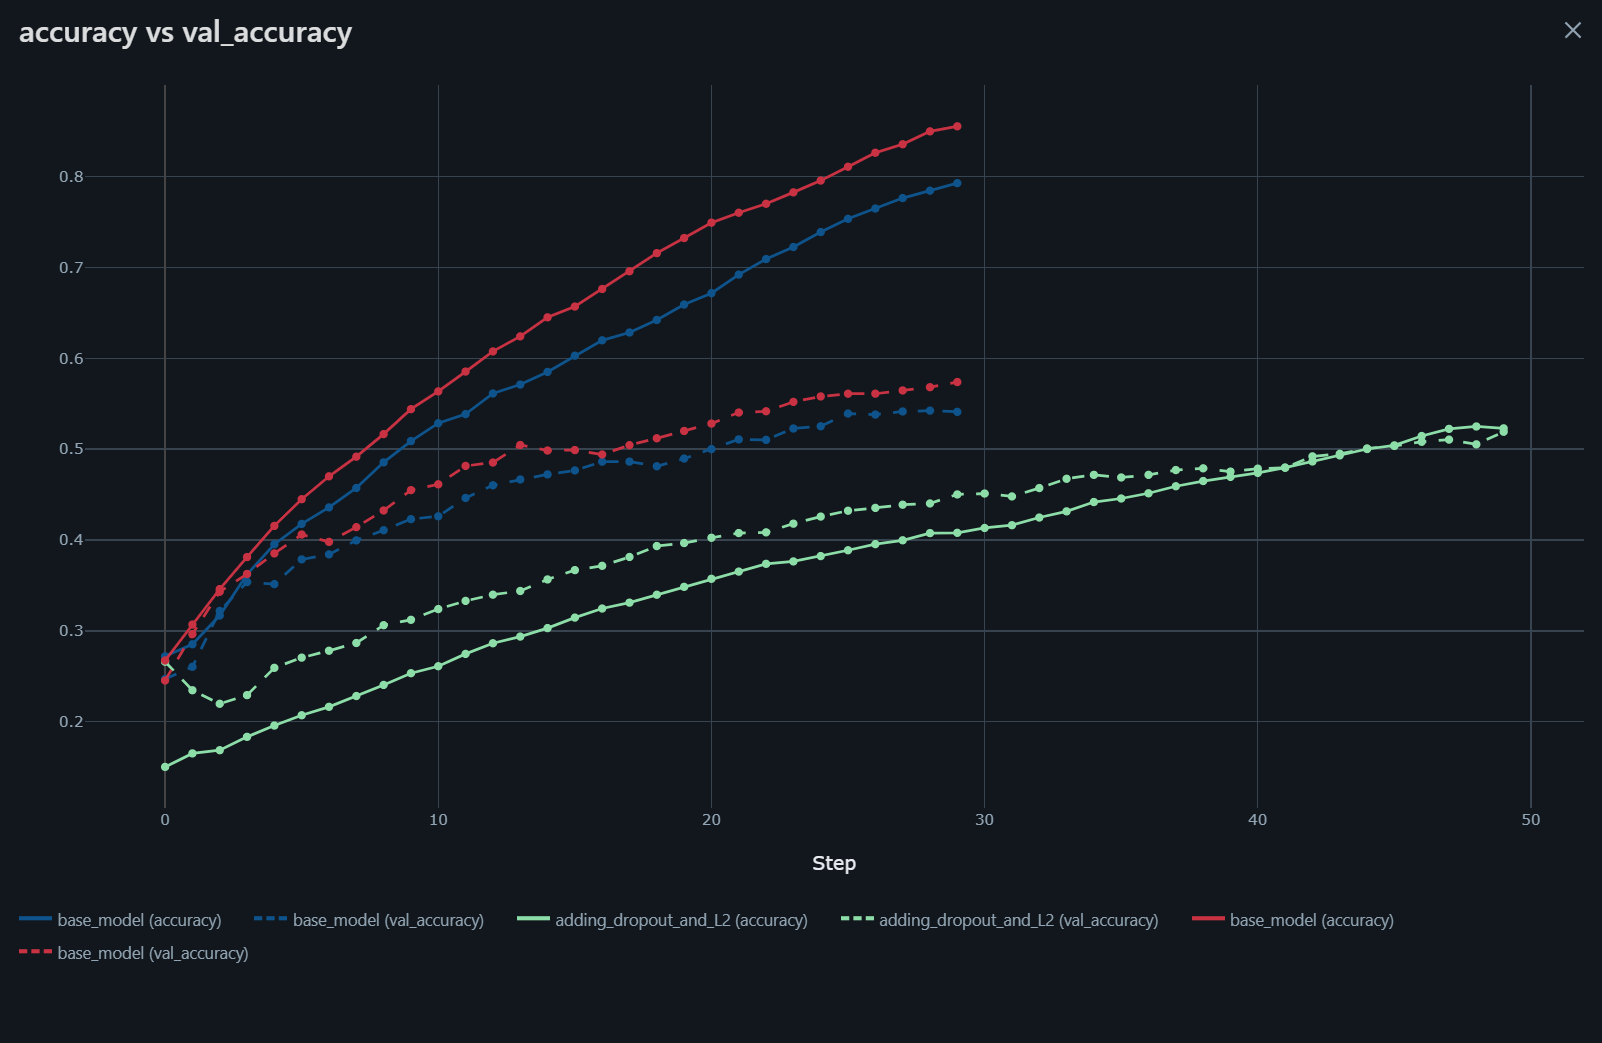

# Implementing a CNN

In [38]:
# Create train, validation and test sets

def prepare_dataset(test_size, validation_size):
    # load data
    X, y = load_data("data.json")    
    
    # Create train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    # Create train/validation split
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # Transform samples to 3d array for CNN (130, 13, 1)
    X_train = X_train[..., np.newaxis] #4d array
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test
    
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_dataset(0.25, 0.2)

In [39]:
X_train.shape

(5991, 130, 13, 1)

In [71]:
# Build the CNN net

def build_model(input_shape):
    # Create model
    model = keras.Sequential()
    
    # First conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    
    # Second conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    
    
    # Third conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    
    # Flatten the output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))
    
    # Output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model
    

input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
model = build_model(input_shape)

In [72]:
input_shape

(130, 13, 1)

In [73]:
model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)                   │ (None, 128, 11, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 64, 6, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 64, 6, 32)           │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 62, 4, 32)           │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 31, 2, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 31, 2, 32)           │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 30, 1, 32)           │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 15, 1, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 15, 1, 32)           │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 64)                  │          30,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 45,514 (177.79 KB)

 Trainable params: 45,322 (177.04 KB)

 Non-trainable params: 192 (768.00 B)

In [74]:
# Complile the network
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
             loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [75]:
# Start an MLflow run to track parameters, metrics, and the model
with mlflow.start_run(run_name="CNN_model"):
    # Train the CNN
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

    # log key data into MLFlow
    mlflow.keras.log_model(model, "model")
    mlflow.log_param("epochs", 30)
    mlflow.log_param("batch_size", 32)
    mlflow.log_param("learning_rate", 0.0001)

    for epoch in range(len(history.history['loss'])):
        mlflow.log_metric("loss", history.history['loss'][epoch], step=epoch)
        mlflow.log_metric("accuracy", history.history['accuracy'][epoch], step=epoch)
        mlflow.log_metric("val_loss", history.history['val_loss'][epoch], step=epoch)
        mlflow.log_metric("val_accuracy", history.history['val_accuracy'][epoch], step=epoch)

    # Evaluate the final model on the test set and log final metrics
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("test_accuracy", test_acc)
    
print(f"Accuracy on test set is : {test_acc:.3f}")

Epoch 1/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.1526 - loss: 2.7394 - val_accuracy: 0.3224 - val_loss: 1.8899
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3214 - loss: 1.9207 - val_accuracy: 0.4366 - val_loss: 1.5598
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4187 - loss: 1.6531 - val_accuracy: 0.4933 - val_loss: 1.4027
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4501 - loss: 1.5207 - val_accuracy: 0.5427 - val_loss: 1.3127
Epoch 5/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4897 - loss: 1.4161 - val_accuracy: 0.5634 - val_loss: 1.2455
Epoch 6/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5092 - loss: 1.3518 - val_accuracy: 0.5721 - val_loss: 1.2113
Epoch 7/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5342 - loss: 1.2994 - val_accuracy: 0.5908 - val_loss: 1.1593
Epoch 8/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5587 - loss: 1.2216 - val_accurac

2025/07/25 16:21:08 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/25 16:21:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7236 - loss: 0.8233
Accuracy on test set is : 0.721


In [76]:
# Make prediction on a sample
def predict(model, X, y):
    X = X[np.newaxis, ...]
    prediction = model.predict(X) # X => (1, 130, 13, 1)
    # Extract index with max value (prediction [ [0.1, 0.4, ...]])
    predicted_index = np.argmax(prediction, axis=1)
    print(f"Expected index : {y}, Predicted index : {predicted_index}")
    
    
X = X_test[100]
y = y_test[100]
predict(model, X, y)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Expected index : 8, Predicted index : [8]


CCL : The CNN performs much better than the basic neural network.

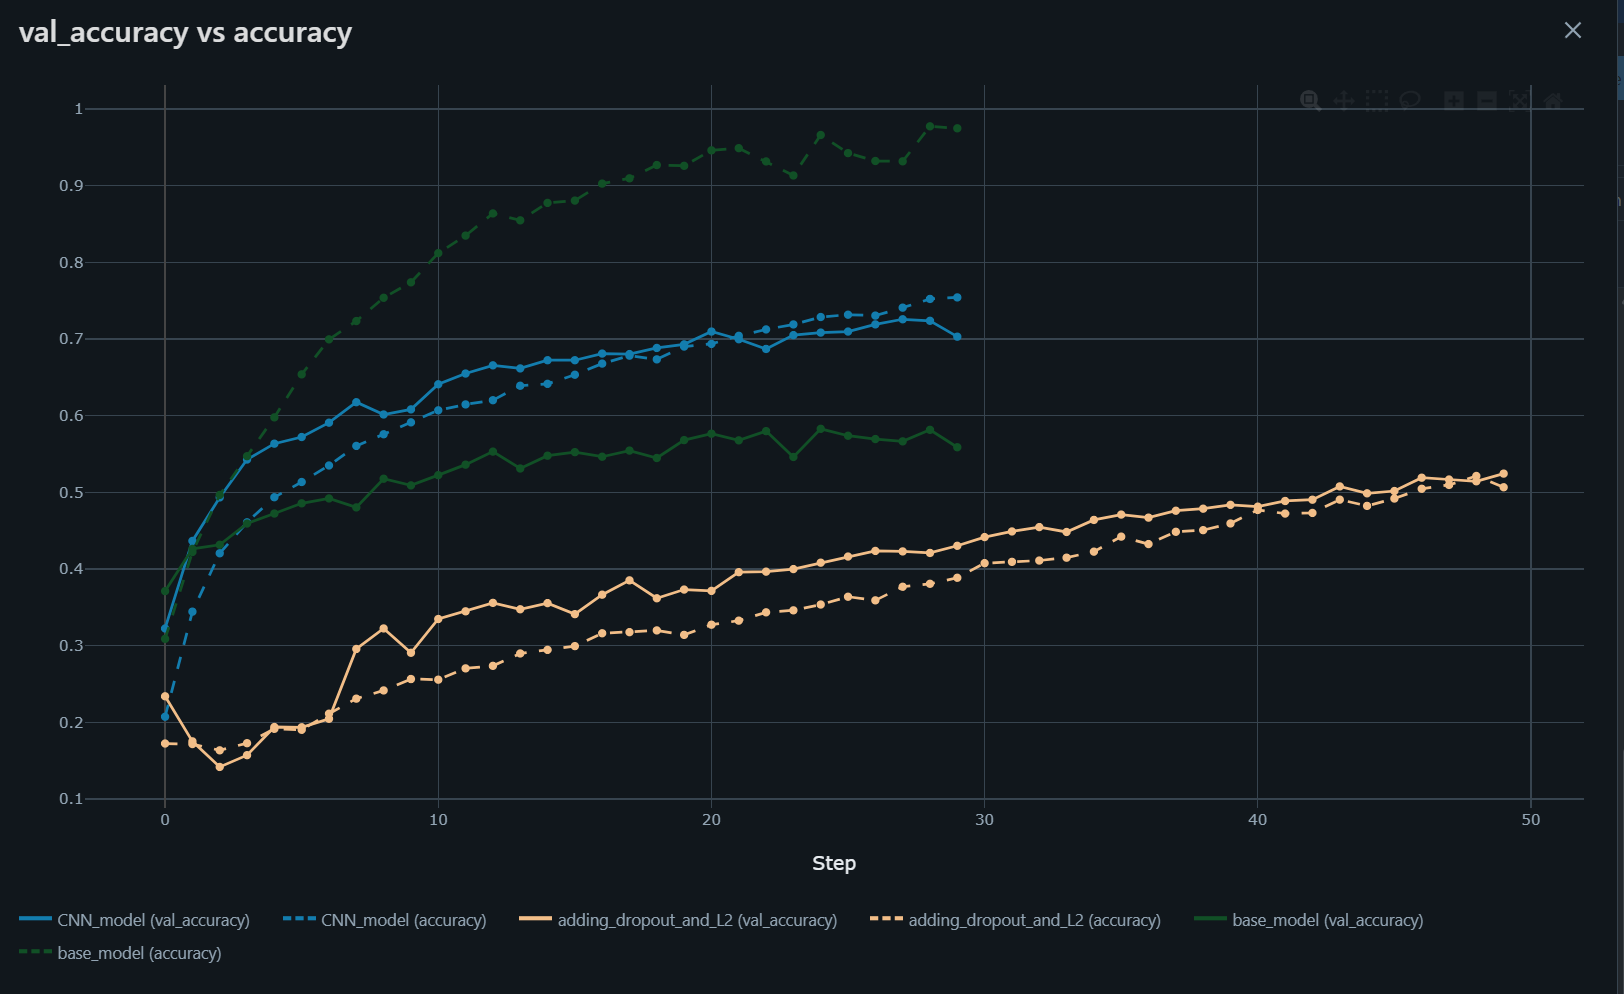

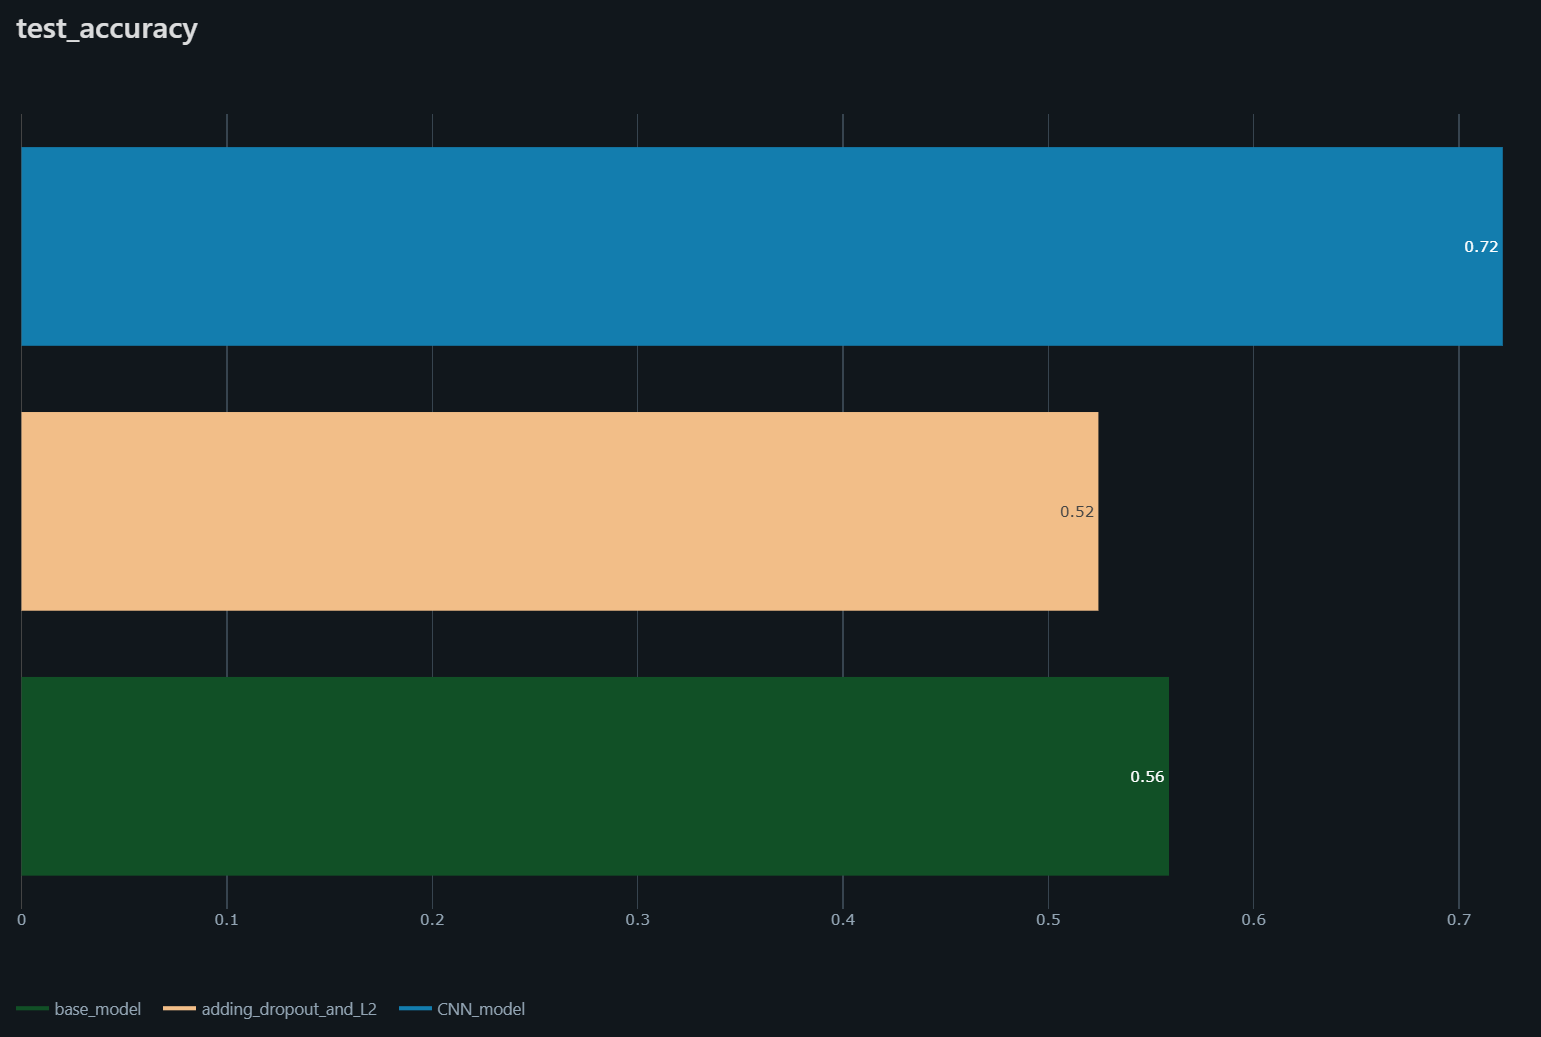

Accuracy: The CNN model significantly outperforms the feedforward neural network in terms of accuracy on both the training and validation sets. The CNN achieved a test accuracy of 0.7236 compared to 0.5341 for the feedforward network.

Loss: The CNN model also shows lower loss values on both the training and validation sets, indicating better performance and generalization.

Architecture: CNNs is more suitable for image data due to their ability to capture spatial hierarchies through convolutional layers. MFCCs images seems to carry enough specific information to be considered as images in classification tasks.

Training Process: Both models were trained with dropout layers to prevent overfitting, but the CNN benefits from additional techniques like batch normalization, which stabilizes and potentially accelerates training.

In conclusion, the CNN model is more effective for music genre classification, due to its ability to handle spatial data from MFCCS more efficiently.

# Implementing a RNN-LSTM

In [78]:
# Create train, validation and test sets

def prepare_RNN_dataset(test_size, validation_size):
    # load data
    X, y = load_data("data.json")    
    
    # Create train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    # Create train/validation split
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    return X_train, X_validation, X_test, y_train, y_validation, y_test
    
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_RNN_dataset(0.25, 0.2)

In [79]:
X_train.shape

(5991, 130, 13)

In [80]:
# Build the RNN-LSTM model

def build_model(input_shape):
    # Create model
    model = keras.Sequential()

    model.add(keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(keras.layers.LSTM(64))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))
    
    # Output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model
    

input_shape = (X_train.shape[1], X_train.shape[2])
model = build_model(input_shape)

C:\Users\OmenH\anaconda3\envs\OCProjectEnv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [81]:
input_shape

(130, 13)

In [82]:
model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 130, 64)             │          19,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57,802 (225.79 KB)

 Trainable params: 57,802 (225.79 KB)

 Non-trainable params: 0 (0.00 B)

In [83]:
# Complile the network
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
             loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [84]:
# Start an MLflow run to track parameters, metrics, and the model
with mlflow.start_run(run_name="RNN-LSTM_model"):
    # Train the CNN
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

    # log key data into MLFlow
    mlflow.keras.log_model(model, "model")
    mlflow.log_param("epochs", 30)
    mlflow.log_param("batch_size", 32)
    mlflow.log_param("learning_rate", 0.0001)

    for epoch in range(len(history.history['loss'])):
        mlflow.log_metric("loss", history.history['loss'][epoch], step=epoch)
        mlflow.log_metric("accuracy", history.history['accuracy'][epoch], step=epoch)
        mlflow.log_metric("val_loss", history.history['val_loss'][epoch], step=epoch)
        mlflow.log_metric("val_accuracy", history.history['val_accuracy'][epoch], step=epoch)

    # Evaluate the final model on the test set and log final metrics
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("test_accuracy", test_acc)
    
print(f"Accuracy on test set is : {test_acc:.3f}")

Epoch 1/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.1323 - loss: 2.2914 - val_accuracy: 0.3044 - val_loss: 2.1560
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.2643 - loss: 2.1198 - val_accuracy: 0.3652 - val_loss: 1.9082
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.3615 - loss: 1.8772 - val_accuracy: 0.4206 - val_loss: 1.6981
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.3954 - loss: 1.7115 - val_accuracy: 0.4332 - val_loss: 1.5914
Epoch 5/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.4221 - loss: 1.6275 - val_accuracy: 0.4579 - val_loss: 1.5329
Epoch 6/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.4446 - loss: 1.5821 - val_accuracy: 0.4613 - val_loss: 1.4838
Epoch 7/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.4765 - loss: 1.4750 - val_accuracy: 0.4640 - val_loss: 1.4613
Epoch 8/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.4774 - loss: 1.4701 - val_acc

2025/07/27 14:24:52 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/27 14:25:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6201 - loss: 1.1188
Accuracy on test set is : 0.625


In [85]:
# Make prediction on a sample
def predict(model, X, y):
    X = X[np.newaxis, ...]
    prediction = model.predict(X) # X => (1, 130, 13, 1)
    # Extract index with max value (prediction [ [0.1, 0.4, ...]])
    predicted_index = np.argmax(prediction, axis=1)
    print(f"Expected index : {y}, Predicted index : {predicted_index}")
    
    
X = X_test[100]
y = y_test[100]
predict(model, X, y)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
Expected index : 5, Predicted index : [5]
